# Complexity Score Prediction Baselines: (S)TF-IDF Baseline Experiments
#### Multilingual Question Type Classification and Complexity Prediction

In this notebook we will be developing a set of baselines for complexity score prediction using subword TF-IDF vectors generated with the text2text toolkit. 

##### Author: Robin Kokot
##### Date: March 2025


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datasets import load_dataset
import wandb
import logging
import time
import os
from sklearn.model_selection import GridSearchCV

# ==================== Set up displays

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# ==================== Set up seed constant

SEED = 69
np.random.seed(SEED)

In [13]:
# ==================== Wandb config
run = wandb.init(project="MAIthesis", name="xgboost-reg-baseline", tags=["baseline", "xgboost", "question-complexity", "regression", "tfidf"],     job_type="model-training")

config = wandb.config
config.max_depth = 6
config.learning_rate = 0.1
config.n_estimators = 200
config.objective = 'reg:squarederror'
config.random_state = 69
config.subsample = 0.8
config.colsample_bytree = 0.8
config.early_stopping_rounds = 20
config.eval_metric=['rmse', 'mae']

wandb.run.notes = "Baseline experiments for question complexity prediction using XGBoost regressor on subword TF-IDF vectors"


In [14]:
# ==================== Dataset loading and label config
dataset = load_dataset("rokokot/question-type-and-complexity-v2")
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
dev = pd.DataFrame(dataset['validation'])

# ==================== Normalize total complexity scores
def normalize_complexity_scores(df):    # normalize total scores, per language
  df['lang_norm_complexity_score'] = 0.0
  for language, group in df.groupby('language'):
    min_score = group['complexity_score'].min()
    max_score = group['complexity_score'].max()
    if min_score == max_score:
      df.loc[df['language'] == language, 'lang_norm_complexity_score'] = 0.5
    else:
      normalized_scores = (group['complexity_score'] - min_score) / (max_score - min_score)
      df.loc[df['language'] == language, 'lang_norm_complexity_score'] = normalized_scores.values
  return df

train_df = normalize_complexity_scores(train)
test_df = normalize_complexity_scores(test)
dev_df = normalize_complexity_scores(dev)

print("Original vs Language-Normalized scores (sample from different languages):")
sample_df = train_df.groupby('language').head(2).reset_index(drop=True)

display(sample_df[['language', 'complexity_score', 'lang_norm_complexity_score']])


Original vs Language-Normalized scores (sample from different languages):


,language,complexity_score,lang_norm_complexity_score
0,fi,1.459,0.360751
1,ru,1.243,0.253591
2,fi,1.455,0.359693
3,ko,2.471,0.510456
4,en,1.986,0.515021
5,ru,1.307,0.271271
6,id,2.698,0.624780
7,ko,2.310,0.467292
8,ja,1.889,0.499308
9,en,2.416,0.656983


In [15]:
y_train = np.array(train_df['lang_norm_complexity_score'])
y_dev = np.array(dev_df['lang_norm_complexity_score'])
y_test = np.array(test_df['lang_norm_complexity_score'])

print(f"Train target distribution: mean={y_train.mean():.4f}, std={y_train.std():.4f}, min={y_train.min():.4f}, max={y_train.max():.4f}")
print(f"Test target distribution: mean={y_test.mean():.4f}, std={y_test.std():.4f}, min={y_test.min():.4f}, max={y_test.max():.4f}")
print(f"Validation target distribution: mean={y_dev.mean():.4f}, std={y_dev.std():.4f}, min={y_dev.min():.4f}, max={y_dev.max():.4f}")


Train target distribution: mean=0.3855, std=0.1693, min=0.0000, max=1.0000
Test target distribution: mean=0.4294, std=0.2127, min=0.0000, max=1.0000
Validation target distribution: mean=0.4466, std=0.2359, min=0.0000, max=1.0000


In [16]:

# ==================== TFIDF vectors loading
print("\nLoading TF-IDF vectors...")
train_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_train.pkl"
dev_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_dev.pkl"
test_vectors = "/home/robin/Research/qtype-eval/scripts/baselines/vectors/tfidf_vectors_test.pkl"

with open(train_vectors, 'rb') as v:
    X_train = pickle.load(v)
with open(dev_vectors, 'rb') as v:
    X_dev = pickle.load(v)
with open(test_vectors, 'rb') as v:
    X_test = pickle.load(v)

print("\nChecking shapes of features and targets:")
print(f"Train - Features: {X_train.shape[0]}, Targets: {y_train.shape[0]}")
print(f"Test - Features: {X_test.shape[0]}, Targets: {y_test.shape[0]}")
print(f"Validation - Features: {X_dev.shape[0]}, Targets: {y_dev.shape[0]}")



Loading TF-IDF vectors...

Checking shapes of features and targets:
Train - Features: 7460, Targets: 7460
Test - Features: 719, Targets: 719
Validation - Features: 441, Targets: 441


In [17]:
print("X_train type:", type(X_train))
if hasattr(X_train, 'shape'):
    print("X_train shape:", X_train.shape)
elif isinstance(X_train, list):
    print("X_train is a list of length:", len(X_train))
    print("First element type:", type(X_train[0]))

import numpy as np
from scipy.sparse import vstack

# Extract sparse matrices from the array and stack them
sparse_matrices = [matrix[0] for matrix in X_train]  # Assuming each row has a single element
X_train_stacked = vstack(sparse_matrices)

sparse_matrices = [matrix[0] for matrix in X_dev]  # Assuming each row has a single element
X_dev_stacked = vstack(sparse_matrices)

# Same for test data
sparse_matrices_test = [matrix[0] for matrix in X_test]
X_test_stacked = vstack(sparse_matrices_test)

X_train type: <class 'numpy.ndarray'>
X_train shape: (7460, 1)


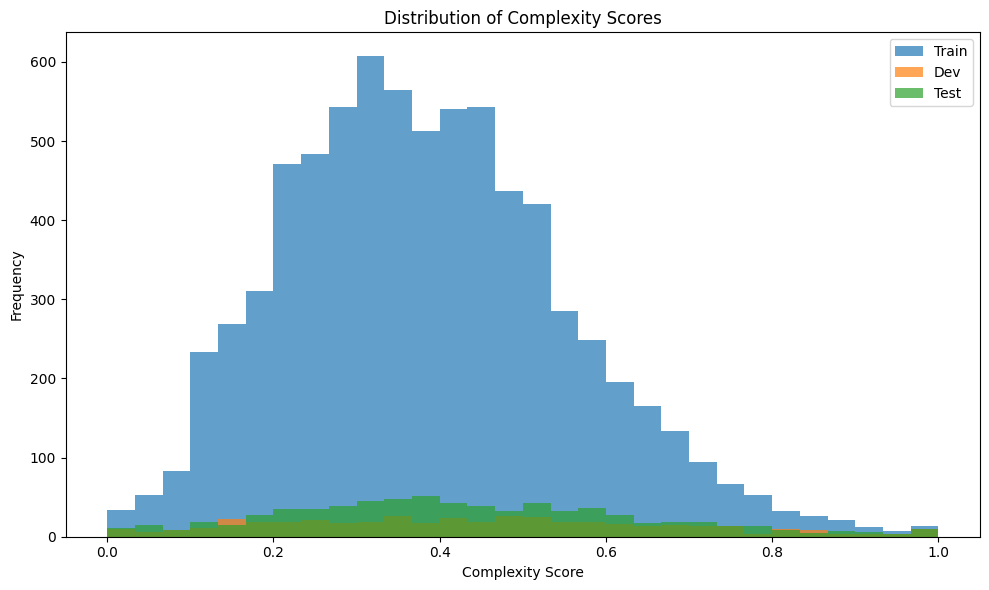

In [10]:
# ==================== Visualization of complexity score distribution
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_dev, bins=30, alpha=0.7, label='Dev')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.xlabel('Complexity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Complexity Scores')
plt.legend()
plt.tight_layout()
wandb.log({"complexity_distribution": wandb.Image(plt)})

In [20]:
# ==================== XGBoost Training and Evaluation
xgb_reg = xgb.XGBRegressor(
    max_depth=config.max_depth,
    learning_rate=config.learning_rate,
    n_estimators=config.n_estimators,
    objective=config.objective,
    random_state=config.random_state,
    subsample=config.subsample,
    eval_metric=['rmse', 'mae'],
    colsample_bytree=config.colsample_bytree,
    early_stopping_rounds=config.early_stopping_rounds
)

wandb.config.update({
    "model_type": "XGBoost",
    "feature_type": "TF-IDF",
    "train_samples": X_train_stacked.shape[0],
    "test_samples": X_test_stacked.shape[0],
    "dev_samples": X_dev_stacked.shape[0],
    "feature_dim": X_train_stacked.shape[1]
})

In [21]:
start_time = time.time()

xgb_reg.fit(X_train_stacked, y_train, eval_set=[(X_train_stacked, y_train), (X_dev_stacked, y_dev)],verbose=100)

training_time = time.time() - start_time
print(f"training took {training_time:.2f} seconds")
wandb.log({"training_time": training_time})

[0]	validation_0-rmse:0.16392	validation_0-mae:0.13164	validation_1-rmse:0.23759	validation_1-mae:0.19293


KeyboardInterrupt: 

In [ ]:
# ==================== Model Evaluation
print("\nEvaluating model on development set...")
y_pred_dev = xgb_reg.predict(X_dev)

rmse_dev = np.sqrt(mean_squared_error(y_dev, y_pred_dev))
mae_dev = mean_absolute_error(y_dev, y_pred_dev)
r2_dev = r2_score(y_dev, y_pred_dev)

print(f"Dev Set: RMSE = {rmse_dev:.4f}, MAE = {mae_dev:.4f}, R² = {r2_dev:.4f}")
wandb.log({"dev_rmse": rmse_dev, "dev_mae": mae_dev, "dev_r2": r2_dev})

plt.figure(figsize=(8, 8))
plt.scatter(y_dev, y_pred_dev, alpha=0.5)
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')
plt.xlabel('Actual Complexity')
plt.ylabel('Predicted Complexity')
plt.title('Predicted vs Actual Complexity (Dev Set)')
plt.tight_layout()
wandb.log({"dev_predictions_scatter": wandb.Image(plt)})

plt.figure(figsize=(8, 6))
residuals = y_pred_dev - y_dev
plt.scatter(y_pred_dev, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Complexity')
plt.ylabel('Residuals')
plt.title('Residual Plot (Dev Set)')
plt.tight_layout()
wandb.log({"dev_residuals": wandb.Image(plt)})

In [ ]:
# ==================== Evaluating on test set
print("\nEvaluating model on test set...")
y_pred_test = xgb_reg.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set: RMSE = {rmse_test:.4f}, MAE = {mae_test:.4f}, R² = {r2_test:.4f}")
wandb.log({"test_rmse": rmse_test, "test_mae": mae_test, "test_r2": r2_test})

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Complexity')
plt.ylabel('Predicted Complexity')
plt.title('Predicted vs Actual Complexity (Test Set)')
plt.tight_layout()
wandb.log({"test_predictions_scatter": wandb.Image(plt)})

plt.figure(figsize=(8, 6))
residuals = y_pred_test - y_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Complexity')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.tight_layout()
wandb.log({"test_residuals": wandb.Image(plt)})


In [ ]:
# ==================== Feature Importance Analysis
print("\nAnalyzing feature importance...")
importance = xgb_reg.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature_index': range(len(importance)),
    'importance': importance
}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(20)
print("Top 20 important features:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.bar(range(20), top_features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
wandb.log({"feature_importance": wandb.Image(plt)})
wandb.log({"feature_importance_table": wandb.Table(
    data=[[int(idx), float(imp)] for idx, imp in zip(top_features['feature_index'], top_features['importance'])],
    columns=["feature_index", "importance"])
})

In [ ]:
# ==================== Save Model
model_path = 'xgboost_regression_baseline_model.json'
xgb_reg.save_model(model_path)
wandb.save(model_path)

In [ ]:
# add analysis by language

In [ ]:
# plot roc and learning curves

In [ ]:
# add hyperparameter tuning

In [ ]:
wandb.finish()